# Multiple databses processing processing

In [1]:
from netCDF4 import Dataset
import os
from os import walk
from os.path import join

from geopy import distance
import numpy as np
import pandas as pd

from datetime import datetime
from datetime import timedelta
import random

import matplotlib.pyplot as plt

from tqdm import tqdm

## DB to csv

In [2]:
PATH_DATABASES = "../afsV3"

# For the moment we are going to use one day
DAY_DATABASE = list(os.walk(PATH_DATABASES))[1][0]  
DATASABES_NAME = list(os.walk(PATH_DATABASES))[1][2]

DAY_DATABASE_OUTPUT = '../afsV3_csv/2020-12'

In [27]:
for db_name in DATASABES_NAME:
    file_path = os.path.join(DAY_DATABASE, db_name)
    ds = Dataset(file_path)
    
    type_boat = ds.variables['type'][:]
    lon = ds.variables['lon'][:]
    lat = ds.variables['lat'][:]
    
    distance_array = []
    non_masked_values_lat_lon = []
    # It takes a lot of processing power
    for id_boat in range(len(lat.data)):
        lat_lon = list(zip(np.array(lat[id_boat].data[~lat[id_boat].mask]), np.array(lon[id_boat].data[~lon[id_boat].mask])))
        lat_lon_cp = lat_lon.copy()

        lat_lon.pop()
        lat_lon_cp.pop(0)

        total_distance = sum(list(map(lambda x, y: distance.distance(x, y).km, lat_lon, lat_lon_cp)))
        distance_array.append(total_distance)
        non_masked_values_lat_lon.append(len(lat_lon))
        
    # Boats that traveled more than 50000 km
    index_superior_distance = np.where(np.array(distance_array) > 50000)

    # Boats that traveled less than 10 km
    index_inferior_distance = np.where(np.array(distance_array) < 10)

    # Boats that have more than 5000 observations
    index_masked_values = np.where(np.array(non_masked_values_lat_lon) > 5000)

    # Boats that don't have a class
    index_no_class = np.where(np.array(type_boat.data == 0))

    index_to_remove = np.unique(np.concatenate((index_superior_distance[0], 
                                                index_inferior_distance[0], 
                                                index_masked_values[0],
                                                index_no_class[0]
                                               ), axis=None))
        
    type_boat = np.delete(ds.variables['type'][:], index_to_remove) # Doesn't have fill value
    mmsi = np.delete(ds.variables['mmsi'][:], index_to_remove) # Doesn't have fill value
    time = np.delete(ds.variables['time'][:], index_to_remove, 0) # Fill value -2147483600.0
    lon = np.delete(ds.variables['lon'][:], index_to_remove, 0) # Fill value -999.0
    lat = np.delete(ds.variables['lat'][:], index_to_remove, 0) # Fill value -99.0
    cog = np.delete(ds.variables['cog'][:], index_to_remove, 0) # Fill value 1023.0,
    sog = np.delete(ds.variables['sog'][:], index_to_remove, 0) # Fill value 3600.0
    trh = np.delete(ds.variables['trh'][:], index_to_remove, 0) # Fill value 511.0
    
    df_complete = pd.DataFrame(columns=['mmsi', 'lat', 'lon', 'cog', 'sog', 'trh', 'time', 
                           'formatted_time', 'formatted_date', 'seq_number', 'observation_id'])

    for id_boat in range(len(lat.data)):
        lat_aux = lat[id_boat].data[~(lat[id_boat].data == lat.fill_value)]
        lon_aux = lon[id_boat].data[~(lon[id_boat].data == lon.fill_value)]
        cog_aux = cog[id_boat].data[~(cog[id_boat].data == cog.fill_value)]
        sog_aux = sog[id_boat].data[~(sog[id_boat].data == sog.fill_value)]
        trh_aux = trh[id_boat].data[~(trh[id_boat].data == trh.fill_value)]
        time_aux = time[id_boat].data[~(time[id_boat].data == time.fill_value)]

        if (len(lat_aux) == len(lon_aux) == len(cog_aux) == len(sog_aux) == len(trh_aux) == len(time_aux)):
            data = {'mmsi': str(int(mmsi[id_boat])),
                'boat_type': str(int(type_boat[id_boat])),
                'lat': lat_aux,
                'lon': lon_aux,
                'cog': cog_aux,
                'sog': sog_aux,
                'trh': trh_aux,
                'time': time_aux} 

            df = pd.DataFrame(data) 
            df['formatted_time'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).time().isoformat())
            df['formatted_date'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).date().isoformat())
            df['observation_id'] = id_boat

            ## Should we order by date?
            df_index = df.index.copy()
            df.sort_values('time', ascending=True, inplace=True)

            df['time_diff'] = df.time.diff()
            df['seq_number'] = df_index

            df_complete = df_complete.append(df, ignore_index=True)
            
    df_complete.to_csv(os.path.join(DAY_DATABASE_OUTPUT, db_name.replace(".nc", '.csv')), index = False)

## Data loading from csv

In [3]:
li = []
for db_name in DATASABES_NAME:
    df = pd.read_csv(os.path.join(DAY_DATABASE_OUTPUT, db_name.replace(".nc", '.csv')))
    li.append(df)

In [4]:
for index, value in enumerate(li):
    if index > 0:
        last_val = li[index-1].observation_id.max()
        li[index]['observation_id'] = li[index]['observation_id'] + last_val + 1

In [5]:
df_complete = pd.concat(li, axis=0, ignore_index=True)
df_complete = df_complete[df_complete.time_diff != 0]

## Data statistics

In [7]:
df_complete

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff
0,256448000,-33.005668,27.973972,12.400000,0.0,217.0,1.606781e+09,01:03:43,2020-12-01,0,0,70,NaN
1,256448000,-33.005613,27.973855,2.200000,0.3,210.0,1.606782e+09,01:12:45,2020-12-01,1,0,70,542.0
2,256448000,-33.005603,27.973860,33.799999,0.0,214.0,1.606782e+09,01:15:45,2020-12-01,2,0,70,180.0
3,256448000,-33.005617,27.973818,234.899994,0.3,212.0,1.606782e+09,01:18:44,2020-12-01,3,0,70,179.0
4,256448000,-33.005655,27.973780,215.300003,0.2,211.0,1.606782e+09,01:21:40,2020-12-01,4,0,70,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335499,266283000,-30.991200,30.408778,28.400000,14.0,29.0,1.607645e+09,00:57:30,2020-12-11,1281,5877,70,45.0
5335500,266283000,-30.989500,30.409873,29.100000,14.0,29.0,1.607645e+09,00:57:58,2020-12-11,1282,5877,70,28.0
5335501,266283000,-30.987438,30.411178,28.400000,14.0,29.0,1.607645e+09,00:58:35,2020-12-11,1283,5877,70,37.0
5335502,266283000,-30.986420,30.411830,28.299999,13.8,29.0,1.607645e+09,00:58:54,2020-12-11,1284,5877,70,19.0


In [8]:
df_complete.boat_type.value_counts()

70    4810102
30     327207
31      24973
33      20975
52      19134
20       9099
10       5000
32       4560
59       4060
50       2717
60       2386
38        433
57         84
Name: boat_type, dtype: int64

In [9]:
# Number of trajectories by boat type
ntraj = df_complete.groupby('boat_type').observation_id.nunique()
ntraj.sort_values(ascending = True)

boat_type
38       1
57       1
50       3
60       3
32       4
10       5
20       8
59      10
33      15
31      19
52      24
30     235
70    4644
Name: observation_id, dtype: int64

In [10]:
# Number of distinct boats by boat type
ntraj = df_complete.groupby('boat_type').mmsi.nunique()
ntraj.sort_values(ascending = True)

boat_type
10       1
32       1
38       1
50       1
57       1
60       1
31       2
33       2
59       2
20       3
52       5
30      26
70    1587
Name: mmsi, dtype: int64

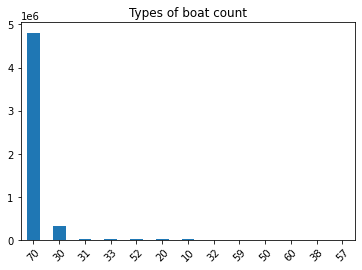

In [11]:
df_complete.boat_type.value_counts().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.title('Types of boat count')
plt.show()

## Trajectories by boat type

In [12]:
import os
os.environ['PROJ_LIB'] = '/home/emilio/anaconda3/envs/fml/share/proj'

from mpl_toolkits.basemap import Basemap

In [17]:
# This is to center the map around the data
lon_0 = sum([df_complete.lon.min(), df_complete.lon.max()])/2
lat_0 = sum([df_complete.lat.min(), df_complete.lat.max()])/2

m = Basemap(width=5000000*(1/3),height=3500000*(1/3),
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

In [18]:
classes_ = ntraj.index.values

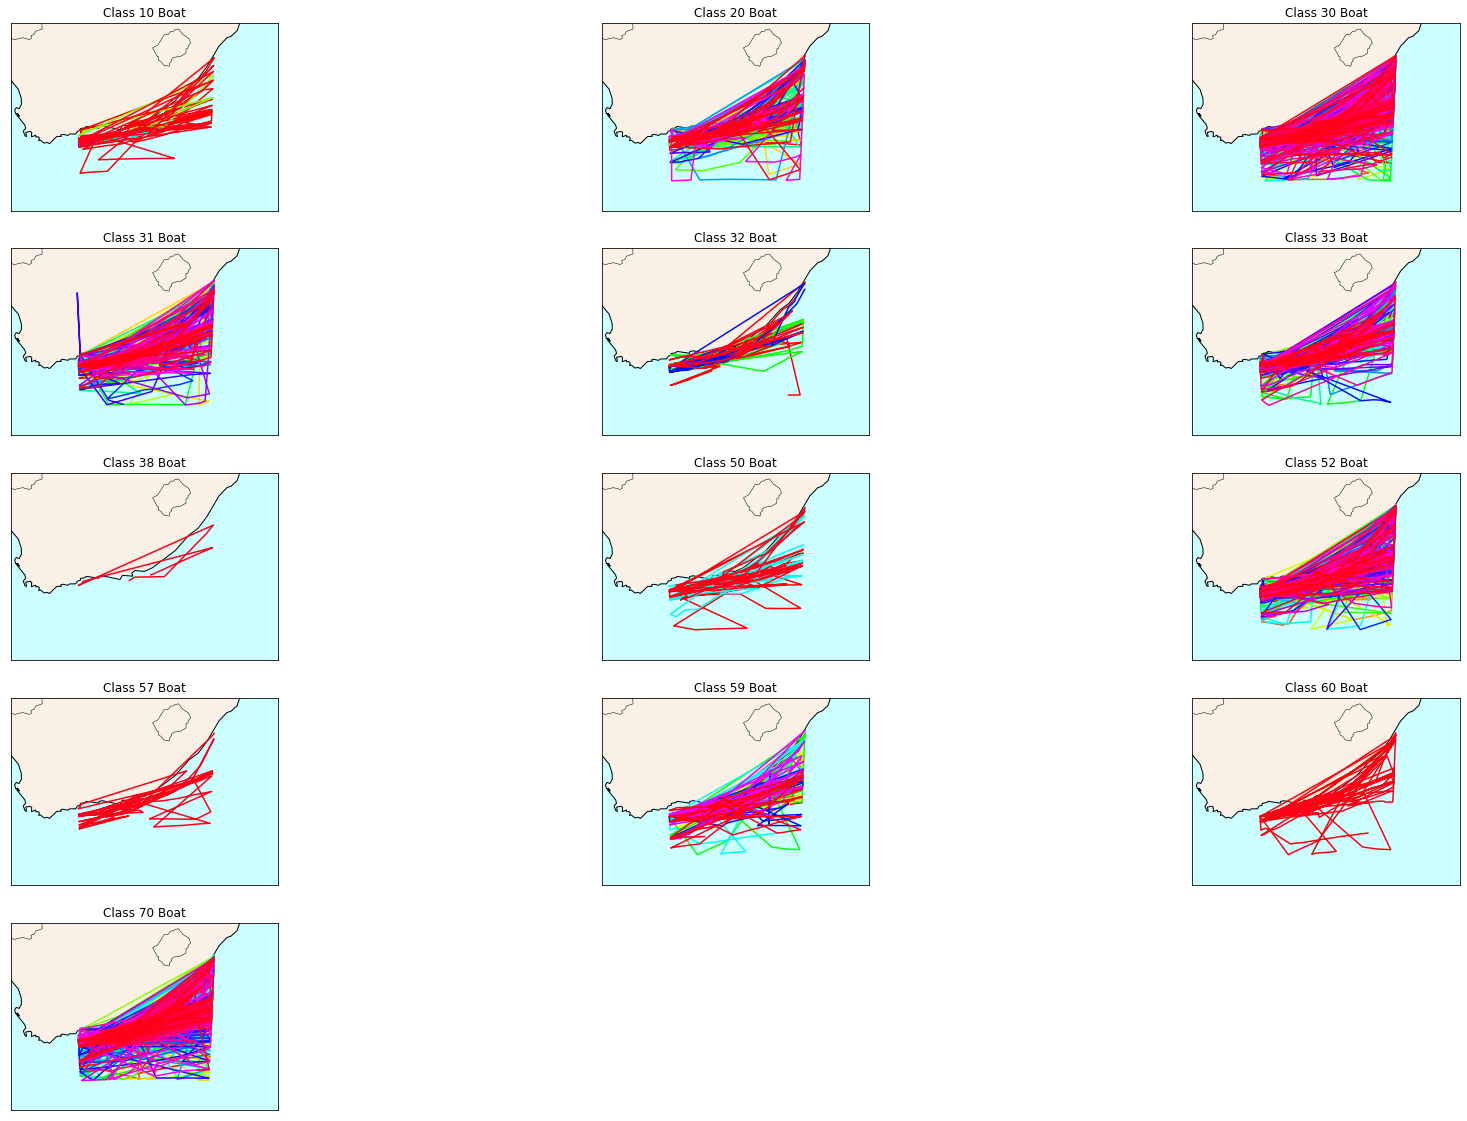

In [19]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(30)

for i in range(len(classes_)):
    traj_id = df_complete[df_complete.boat_type == classes_[i]].observation_id.unique()
    
    ax = fig.add_subplot(5,3, 1 + i)
    ax.set_title(f'Class {classes_[i]} Boat')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    m.drawcounties()
    
    traj_id = df_complete[df_complete.boat_type == classes_[i]].observation_id.unique()
    min_ntraj = 50
    if min_ntraj > len(traj_id): 
        min_ntraj = len(traj_id)
    
    random_sample = np.random.choice(traj_id, min_ntraj, replace = False)
    cmap = plt.cm.get_cmap('hsv', len(random_sample))
    
    idx = 0
    for rs in random_sample:
        lon = df_complete[df_complete.observation_id == rs].lon.values
        lat = df_complete[df_complete.observation_id == rs].lat.values
        x,y = m(lon,lat)
        m.plot(x, y, color=cmap(idx))
        idx += 1

plt.show()

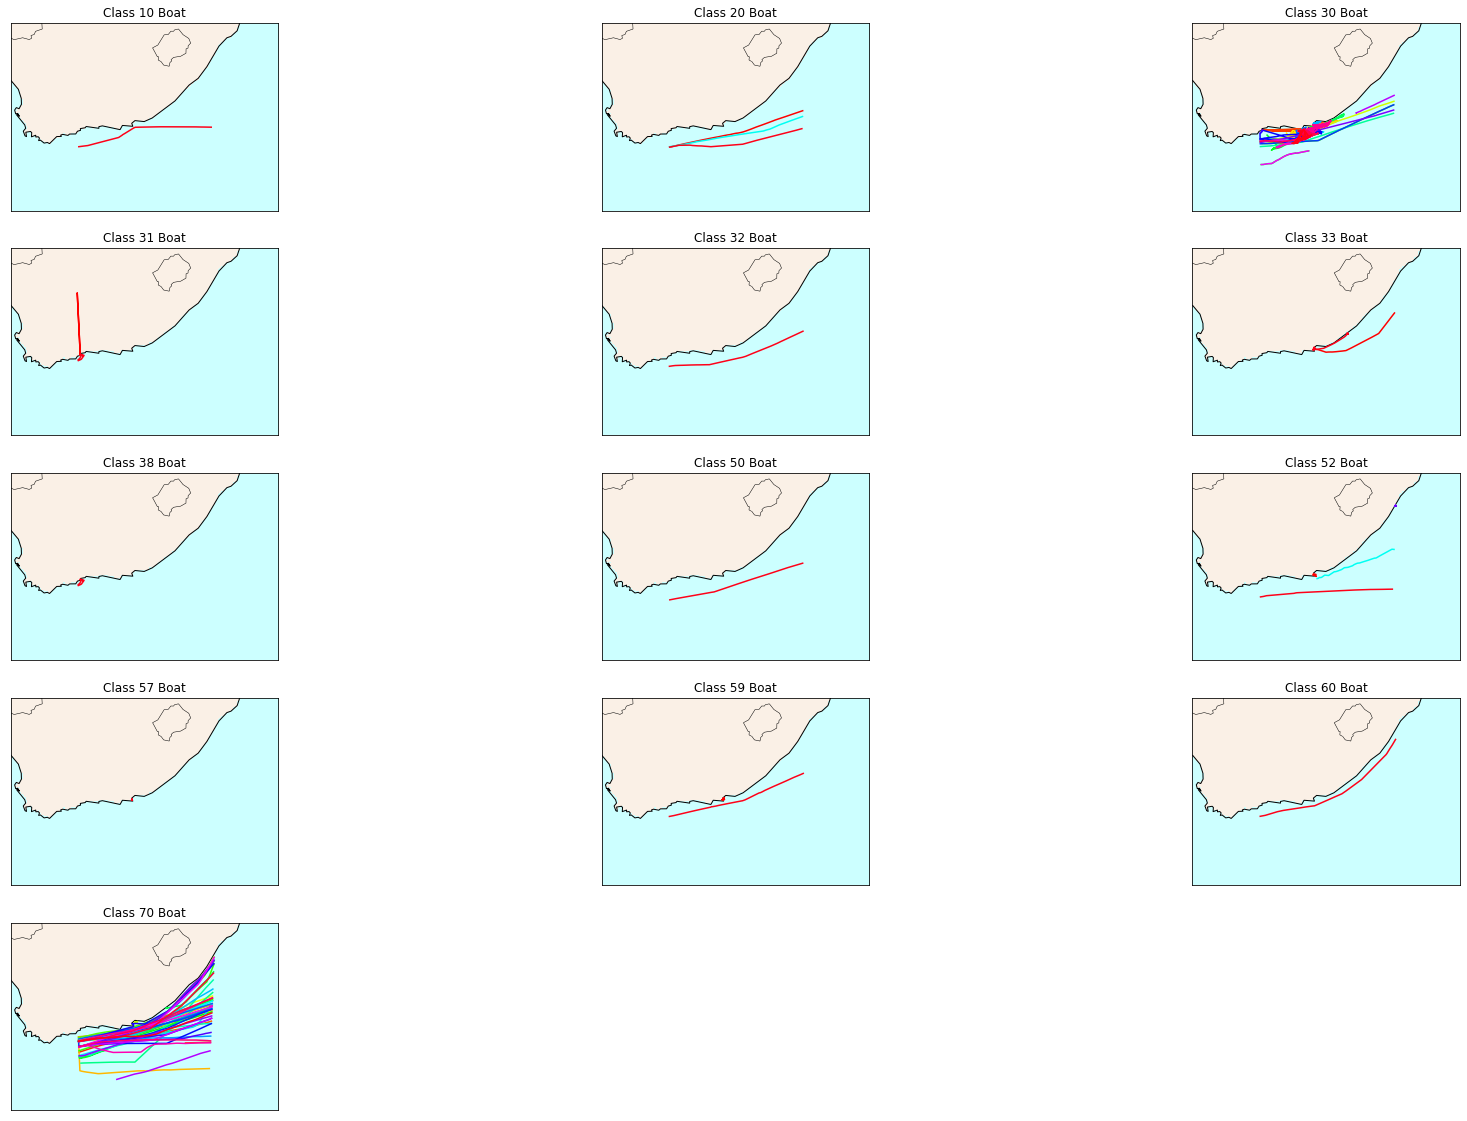

In [126]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(30)

for i in range(len(classes_)):
    traj_id = df_complete[df_complete.boat_type == classes_[i]].mmsi.unique()
    
    ax = fig.add_subplot(5,3, 1 + i)
    ax.set_title(f'Class {classes_[i]} Boat')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    m.drawcounties()
    
    traj_id = df_complete[df_complete.boat_type == classes_[i]].mmsi.unique()
    min_ntraj = 50
    if min_ntraj > len(traj_id): 
        min_ntraj = len(traj_id)
    
    random_sample = np.random.choice(traj_id, min_ntraj, replace = False)
    cmap = plt.cm.get_cmap('hsv', len(random_sample))
    
    idx = 0
    for rs in random_sample:
        lon = df_complete[df_complete.mmsi == rs].sort_values('time').lon.values
        lat = df_complete[df_complete.mmsi == rs].sort_values('time').lat.values
        x,y = m(lon,lat)
        m.plot(x, y, color=cmap(idx))
        idx += 1

plt.show()

## Interpolation of Data

In [6]:
mmsi_unique = df_complete.mmsi.unique()
observation_unique = df_complete.observation_id.unique()

pre_df_interpolated = df_complete.copy()
pre_df_interpolated['datetime'] = pre_df_interpolated.time.apply(lambda x: datetime.fromtimestamp(int(x))).values

observation_list = pre_df_interpolated.observation_id.unique()

In [7]:
pre_df_interpolated.head()

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff,datetime
0,256448000,-33.005668,27.973972,12.400000,0.0,217.0,1.606781e+09,01:03:43,2020-12-01,0,0,70,NaN,2020-12-01 01:03:43
1,256448000,-33.005613,27.973855,2.200000,0.3,210.0,1.606782e+09,01:12:45,2020-12-01,1,0,70,542.0,2020-12-01 01:12:45
2,256448000,-33.005603,27.973860,33.799999,0.0,214.0,1.606782e+09,01:15:45,2020-12-01,2,0,70,180.0,2020-12-01 01:15:45
3,256448000,-33.005617,27.973818,234.899994,0.3,212.0,1.606782e+09,01:18:44,2020-12-01,3,0,70,179.0,2020-12-01 01:18:44
4,256448000,-33.005655,27.973780,215.300003,0.2,211.0,1.606782e+09,01:21:40,2020-12-01,4,0,70,176.0,2020-12-01 01:21:40


In [7]:
def get_observation_id(obs_ids, initial_id = 0, wrong_value = -99, seq_size = 8, n_past = 3):
    i = 0
    counter = 0
    new_obs_ids = []
    new_id = initial_id

    past_pos = 0

    while i < len(obs_ids):
        if counter == seq_size:
            counter = 0
            new_id += 1

        if ~np.isnan(obs_ids[i]):
            past_pos = 0
            new_obs_ids.append(new_id)
            counter += 1
        else:
            past_pos += 1
            if past_pos >= n_past:
                new_obs_ids.append(wrong_value)
                counter = 0
                new_id += 1
            else:
                new_obs_ids.append(new_id)
                counter += 1   
        i += 1   
    return(new_obs_ids)

In [8]:
list_df = []
new_id = 0

for obs in tqdm(observation_list):
    resampled_data = pre_df_interpolated[pre_df_interpolated.observation_id == obs][['lat', 'lon', 'cog', 'sog', 'trh', 'mmsi', 'time', 'datetime', 'boat_type']].drop_duplicates(subset='time', keep="last")
    resampled_data.index = resampled_data['datetime']
    resampled_data = resampled_data.resample(timedelta(seconds=10)).mean()
    resampled_data[['lat', 'lon', 'cog', 'sog', 'trh']] = resampled_data[['lat', 'lon', 'cog', 'sog', 'trh']].interpolate()
    resampled_data['boat_type'] = resampled_data.boat_type[0]
    
    obs_ids = resampled_data.mmsi.values

    res_observation_id = get_observation_id(obs_ids, new_id, -99, 8, 3)
    new_id = max(res_observation_id) +1 
    
    resampled_data['new_id'] = res_observation_id
    resampled_data = resampled_data[resampled_data.new_id > -1].groupby('new_id').filter(lambda x: len(x) == 8)
    list_df.append(resampled_data)
    

100%|███████████████████████████████████████| 4972/4972 [03:43<00:00, 22.25it/s]


In [9]:
df_interpolated = pd.concat(list_df, axis=0, ignore_index=True)

In [10]:
#df_interpolated.to_csv('df_interpolated_8_3.csv', index = False)

## CSV Reading

In [2]:
df_interpolated = pd.read_csv('df_interpolated_8_3.csv')

In [3]:
(df_interpolated.boat_type.value_counts()/8)

70.0    261202.0
30.0     18368.0
31.0      1085.0
52.0      1022.0
33.0       983.0
20.0       624.0
10.0       219.0
59.0       203.0
60.0       145.0
50.0       141.0
32.0       125.0
38.0        28.0
57.0         2.0
Name: boat_type, dtype: float64

<AxesSubplot:>

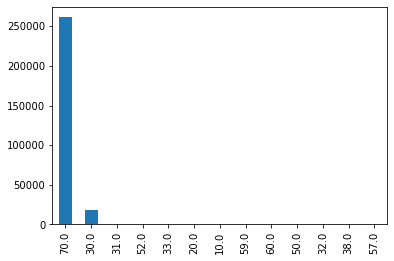

In [4]:
(df_interpolated.boat_type.value_counts()/8).plot(kind = 'bar')

## Trajectory visualization

## NN Implementation

In [5]:
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type=None)

import random

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

pl.seed_everything(42)

2021-11-25 09:50:22.840082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 09:50:22.840106: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-25 09:50:26.079385: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-25 09:50:26.079432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ideapad): /proc/driver/nvidia/version does not exist
Global seed set to 42


42

In [6]:
selected_classes = (df_interpolated.boat_type.value_counts()/8)[(df_interpolated.boat_type.value_counts()/8) > 900].index.values
selected_classes

array([70., 30., 31., 52., 33.])

In [7]:
(df_interpolated.boat_type.value_counts()/8)

70.0    261202.0
30.0     18368.0
31.0      1085.0
52.0      1022.0
33.0       983.0
20.0       624.0
10.0       219.0
59.0       203.0
60.0       145.0
50.0       141.0
32.0       125.0
38.0        28.0
57.0         2.0
Name: boat_type, dtype: float64

In [8]:
n_segments = 950

In [10]:
df_interpolated.head(10)

,lat,lon,cog,sog,trh,mmsi,time,boat_type,new_id
0,-33.014980,27.971100,191.000000,1.200000,214.000000,256448000.0,1.606795e+09,70.0,1281
1,-33.015024,27.971083,191.650002,1.200000,214.500000,NaN,NaN,70.0,1281
2,-33.015068,27.971067,192.300003,1.200000,215.000000,256448000.0,1.606795e+09,70.0,1281
3,-33.015127,27.971053,192.900004,1.166667,215.666667,NaN,NaN,70.0,1281
4,-33.015186,27.971039,193.500005,1.133333,216.333333,NaN,NaN,70.0,1281
5,-33.015244,27.971025,194.100006,1.100000,217.000000,256448000.0,1.606795e+09,70.0,1281
6,-33.015294,27.971011,193.840005,1.100000,217.400000,NaN,NaN,70.0,1281
7,-33.015344,27.970997,193.580005,1.100000,217.800000,NaN,NaN,70.0,1281
8,-33.015795,27.970860,198.300003,1.300000,222.000000,256448000.0,1.606795e+09,70.0,1285
9,-33.015830,27.970852,198.666667,1.166667,222.666667,NaN,NaN,70.0,1285


In [22]:
sampled_classes = []

for cls_ in selected_classes:
    new_id_class = df_interpolated[df_interpolated.boat_type == cls_].new_id.unique()
    sample_id = random.sample(sorted(new_id_class), n_segments)
    df_f = df_interpolated[df_interpolated.new_id.isin(sample_id)]
    sampled_classes.append(df_f)

In [24]:
dataset_interpolated = pd.concat(sampled_classes, axis=0, ignore_index=True)

In [26]:
dataset_interpolated.head()

,lat,lon,cog,sog,trh,mmsi,time,boat_type,new_id
0,-34.417730,27.012645,80.199997,11.40,79.0,374677000.0,1.606818e+09,70.0,14241
1,-34.417638,27.013271,80.149998,11.35,79.5,NaN,NaN,70.0,14241
2,-34.417547,27.013897,80.099998,11.30,80.0,374677000.0,1.606818e+09,70.0,14241
3,-34.417362,27.015222,80.699997,11.40,79.0,374677000.0,1.606818e+09,70.0,14241
4,-34.417281,27.015815,80.549999,11.35,79.0,NaN,NaN,70.0,14241


In [30]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset_interpolated.boat_type) 

In [31]:
dataset_interpolated["label"] = encoded_labels

FEATURE_COLUMNS = ['lat', 'lon', 'cog', 'sog', 'trh']
FEATURE_COLUMNS

['lat', 'lon', 'cog', 'sog', 'trh']

In [33]:
sequences = []

for series_id, group in dataset_interpolated.groupby("new_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = dataset_interpolated[dataset_interpolated.new_id == series_id].iloc[0].label
    
    sequences.append((sequence_features, label))

In [52]:
train_sequences, test_sequences = train_test_split(sequences, test_size = 0.2)

In [53]:
class BoatDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [54]:
class BoatDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = BoatDataset(self.train_sequences)
        self.test_dataset = BoatDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    

In [55]:
N_EPOCHS = 300
BATCH_SIZE = 1000

data_module = BoatDataModule(train_sequences, test_sequences, BATCH_SIZE)

In [56]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

In [57]:
class BoatPredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [58]:
model = BoatPredictor(
    n_features=len(FEATURE_COLUMNS), 
    n_classes=len(selected_classes))

In [59]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5439), started 0:06:23 ago. (Use '!kill 5439' to kill it.)

In [60]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="var_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=0
)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f66b96d7e80>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f66b96d7e80>)`.
  rank_zero_deprecation(
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(


In [61]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.293     Total estimated model params size (MB)
Global seed set to 42
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


In [62]:
trainer.test(dataloaders=data_module)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1391: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/surface/version_2/checkpoints/epoch=299-step=1199.ckpt
Loaded model weights from checkpoint at lightning_logs/surface/version_2/checkpoints/epoch=299-step=1199.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8915789723396301, 'test_loss': 0.32604140043258667}
--------------------------------------------------------------------------------


[{'test_loss': 0.32604140043258667, 'test_accuracy': 0.8915789723396301}]

In [63]:
model.freeze()

test_dataset = BoatDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]
    
    _, output = model(sequence.unsqueeze(dim = 0))
    predictions.append(torch.argmax(output, dim = 1).numpy()[0])
    labels.append(label.item())

100%|████████████████████████████████████████| 950/950 [00:01<00:00, 758.95it/s]


In [72]:
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score
import seaborn as sns

F1 score 0.8943225066964152
Accuracy 0.891578947368421


<AxesSubplot:>

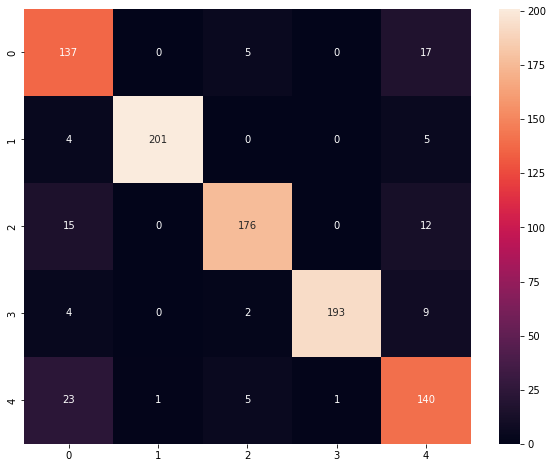

In [73]:
#Get the confusion matrix
nn_matrix = confusion_matrix(predictions, labels)
nn_f1 = f1_score(predictions, labels, average = 'weighted')
nn_ac = accuracy_score(predictions, labels)

print(f'F1 score {nn_f1}') 
print(f'Accuracy {nn_ac}') 

fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(nn_matrix, annot=True, fmt='g')

In [64]:
test_results = pd.DataFrame.from_dict({'predictions': predictions, 'labels': labels})
test_results.head(10)

,predictions,labels
0,3,3
1,0,0
2,2,2
3,3,3
4,0,0
5,2,2
6,3,3
7,0,0
8,1,1
9,3,3


In [65]:
test_results.shape[0]

950

In [66]:
test_results[test_results.predictions == test_results.labels].shape[0]

847

In [67]:
test_results[test_results.predictions != test_results.labels].shape[0]

103

In [68]:
errors_ = test_results[test_results.predictions != test_results.labels]
errors_

,predictions,labels
33,3,4
34,3,4
50,4,2
52,2,0
70,4,0
...,...,...
924,0,4
926,4,0
933,4,3
944,4,0


In [135]:
# Class 70
(errors_.labels == 1).sum()

19

In [136]:
# Class 30
(errors_.labels == 0).sum()

10